In [1]:
import torch
import ujson
import gzip
import string
import random
import sys
import pickle

import numpy as np

from glob import glob
from tqdm import tqdm
from collections import Counter, defaultdict
from itertools import chain, islice, tee
from multiprocessing import Pool

from torch import nn, optim
from torch.nn import functional as F
from torch.nn.utils import rnn
from torch.utils.data import random_split
from torch.utils.data import DataLoader

from headline_parser import parse_headline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [3]:
def read_json_gz_lines(root):
    """Read JSON corpus.

    Yields: dict
    """
    for path in glob('%s/*.gz' % root):
        with gzip.open(path) as fh:
            for line in fh:
                yield ujson.loads(line)

In [4]:
def group_by_sizes(L, sizes):
    """Given a flat list and a list of sizes that sum to the length of the
    list, group the list into sublists with corresponding sizes.

    Args:
        L (list)
        sizes (list<int>)

    Returns: list<list>
    """
    parts = []

    total = 0
    for s in sizes:
        parts.append(L[total:total+s])
        total += s

    return parts

In [5]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
class Corpus:
    
    @classmethod
    def from_spark_lines(cls, root, skim=None):
        
        rows_iter = islice(read_json_gz_lines(root), skim)
        
        # Label -> [line1, line2, ...]
        groups = defaultdict(list)
        for row in tqdm(rows_iter):
            
            doc = parse_headline(row['title'])
            spans = [s.text for s in doc._.spans if s.text]
            
            # Only care about cases where we can remove a split.
            if len(spans) > 1:
                for span in spans:
                        groups[row['domain']].append(span)
                
        return cls(groups)
    
    @classmethod
    def load(cls, path):
        with open(path, 'rb') as fh:
            return pickle.load(fh)
        
    def save(self, path):
        with open(path, 'wb') as fh:
            pickle.dump(self, fh)
    
    def __init__(self, groups, test_frac=0.1):
        self.groups = groups
        self.test_frac = test_frac
        self.set_splits()
        
    def labels(self):
        return list(self.groups)
        
    def min_label_count(self):
        return min([len(v) for v in self.groups.values()])
    
    def set_splits(self):
        
        min_count = self.min_label_count()
        
        pairs = list(chain(*[
            [(line, label) for line in random.sample(lines, min_count)]
            for label, lines in self.groups.items()
        ]))
        
        test_size = round(len(pairs) * self.test_frac)
        train_size = len(pairs) - (test_size * 2)
        sizes = (train_size, test_size, test_size)
        
        self.train, self.val, self.test = random_split(pairs, sizes)

In [8]:
class CharEmbedding(nn.Embedding):

    def __init__(self, embed_dim=15):
        """Set vocab, map s->i.
        """
        self.vocab = (
            string.ascii_letters +
            string.digits +
            string.punctuation
        )

        # <UNK> -> 1
        self._ctoi = {s: i+1 for i, s in enumerate(self.vocab)}

        super().__init__(len(self.vocab)+1, embed_dim)
        
    @property
    def out_dim(self):
        return self.weight.shape[1]

    def ctoi(self, c):
        return self._ctoi.get(c, 0)

    def chars_to_idxs(self, chars):
        """Map characters to embedding indexes.
        """
        idxs = [self.ctoi(c) for c in chars]

        return torch.LongTensor(idxs).to(DEVICE)

    def forward(self, chars):
        """Batch-embed chars.

        Args:
            tokens (list<str>)
        """
        idxs = [self.ctoi(c) for c in chars]
        x = torch.LongTensor(idxs).to(DEVICE)
        
        return super().forward(x)

In [9]:
class SpanEncoder(nn.Module):

    def __init__(self, input_size, hidden_size=100, num_layers=1):
        """Initialize LSTM.
        """
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
        )

        self.out_dim = self.lstm.hidden_size * 2

    def forward(self, xs):
        """Sort, pack, encode, reorder.

        Args:
            xs (list<Tensor>): Variable-length embedding tensors.

        Returns:
            x (Tensor): F/B hidden tops.
        """
        sizes = [len(x) for x in xs]

        # Indexes to sort descending.
        sort_idxs = np.argsort(sizes)[::-1]

        # Indexes to restore original order.
        unsort_idxs = torch.from_numpy(np.argsort(sort_idxs)).to(DEVICE)

        # Sort by size descending.
        xs = [xs[i] for i in sort_idxs]

        # Pad + pack, LSTM.
        x = rnn.pack_sequence(xs)
        _, (hn, _) = self.lstm(x)

        # Cat forward + backward hidden layers.
        x = torch.cat([hn[0,:,:], hn[1,:,:]], dim=1)
        x = x[unsort_idxs]

        return x

In [10]:
class Classifier(nn.Module):

    def __init__(self, labels, hidden_dim=100):
        """Initialize encoders + clf.
        """
        super().__init__()

        self.labels = labels
        self.ltoi = {label: i for i, label in enumerate(labels)}

        self.embed_chars = CharEmbedding()
        self.encode_spans = SpanEncoder(self.embed_chars.out_dim)

        self.dropout = nn.Dropout()

        self.predict = nn.Sequential(
            nn.Linear(self.encode_spans.out_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, len(labels)),
            nn.LogSoftmax(1),
        )

    def forward(self, spans):
        """Predict outlet.
        """
        sizes = [len(s) for s in spans]

        # Embed chars, regroup by line.
        x = self.embed_chars(list(chain(*spans)))
        xs = group_by_sizes(x, sizes)

        # Embed spans.
        x = self.encode_spans(xs)
        x = self.dropout(x)

        return self.predict(x)

    def collate_batch(self, batch):
        """Labels -> indexes.
        """
        lines, labels = list(zip(*batch))

        yt_idx = [self.ltoi[label] for label in labels]
        yt = torch.LongTensor(yt_idx).to(DEVICE)

        return lines, yt

In [11]:
def train_epoch(model, optimizer, split):

    loader = DataLoader(
        split,
        collate_fn=model.collate_batch,
        batch_size=50,
    )

    losses = []
    for spans, yt in tqdm(loader):

        model.train()
        optimizer.zero_grad()

        yp = model(spans)

        loss = loss_func(yp, yt)
        loss.backward()

        optimizer.step()

        losses.append(loss.item())
        
    return losses

In [12]:
def predict(model, split):
    
    model.eval()

    loader = DataLoader(
        split,
        collate_fn=model.collate_batch,
        batch_size=50,
    )
    
    yt, yp = [], []
    for lines, yti in loader:
        yp += model(lines).tolist()
        yt += yti.tolist()
        
    yt = torch.LongTensor(yt)
    yp = torch.FloatTensor(yp)
        
    return yt, yp

In [13]:
def evaluate(model, split):
    yt, yp = predict(model, split)
    return loss_func(yp, yt)

In [14]:
corpus = Corpus.from_spark_lines('data/cleaning-titles.json/', 10000)

10000it [00:04, 2335.64it/s]


In [25]:
corpus.save('data/corpus.p')

In [26]:
corpus = Corpus.load('data/corpus.p')

In [27]:
model = Classifier(corpus.labels())
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_func = nn.NLLLoss()

In [28]:
losses = []
for _ in range(100):
    
    train_epoch(model, optimizer, corpus.train)
    
    loss = evaluate(model, corpus.val)
    losses.append(loss)
    
    print(loss)
    
    if len(losses) > 3 and losses[-1] > losses[-5]:
        break

  5%|▍         | 1/22 [00:00<00:02,  8.49it/s]

tensor(2.7140)


 82%|████████▏ | 18/22 [00:02<00:00,  8.48it/s]


KeyboardInterrupt: 

In [ ]:
weights = []
for span, domain in islice(corpus.train, 1000):
    
    yp = model([span]).exp()
    pred = model.labels[yp.argmax().item()]
    weight = yp.max().item()
    
    if weight > 0.5:
        print(span, domain, pred, weight)
        
    weights.append(weight)

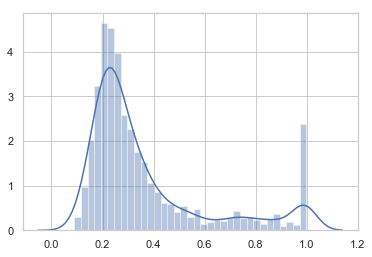

In [234]:
sns.distplot(weights)